<a href="https://colab.research.google.com/github/mdrubel117/-Inheritence2/blob/main/pen_pencil_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

In [8]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Pen: 500 images
Pencil: 500 images


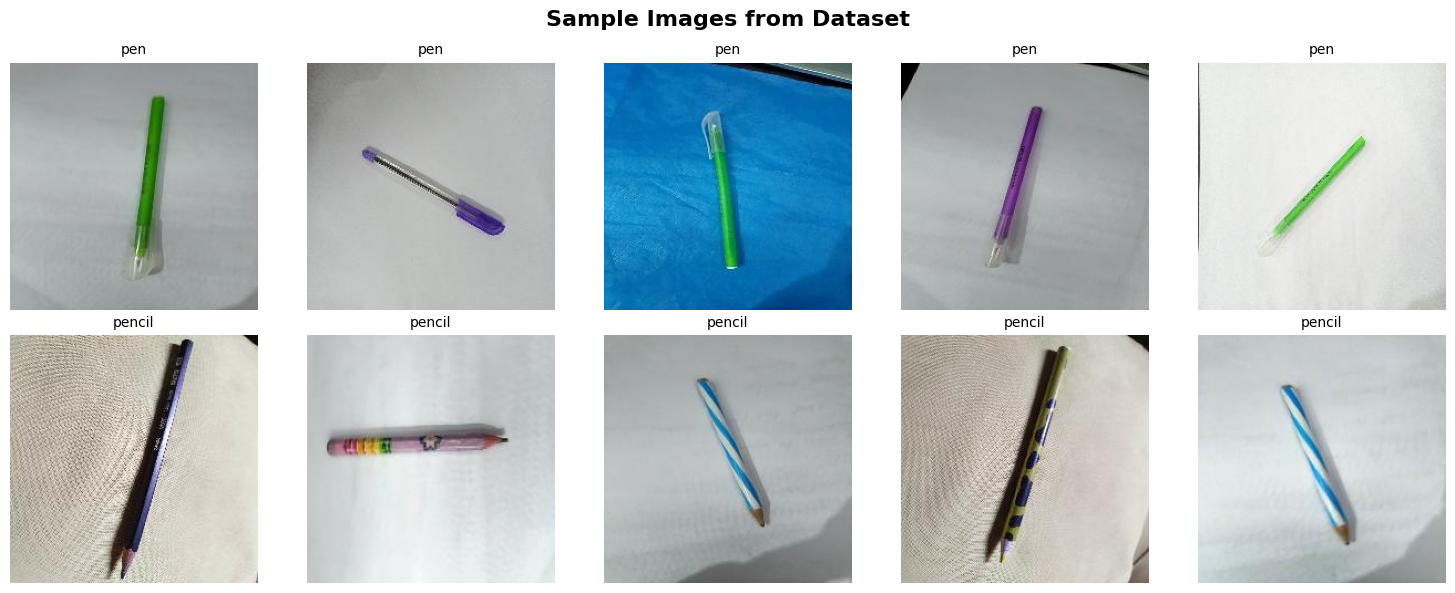

In [9]:
dataset_path = Path("processed_dataset")

classes = ['pen', 'pencil']
for class_name in classes:
    class_path = dataset_path / class_name
    num_images = len(list(class_path.glob('*.jpg')))
    print(f"{class_name.capitalize()}: {num_images} images")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample Images from Dataset", fontsize=16, fontweight='bold')

for i, class_name in enumerate(classes):
    class_path = dataset_path / class_name
    image_files = list(class_path.glob('*.jpg'))[:5]

    for j, img_path in enumerate(image_files):
        img = load_img(img_path, target_size=(224, 224))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{class_name}", fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    str(dataset_path),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    str(dataset_path),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    str(dataset_path),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

print(f"\nClass indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Class indices: {'pen': 0, 'pencil': 1}
Training samples: 800
Validation samples: 200
Test samples: 1000


In [12]:
base_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

print(f"Base model: MobileNetV2")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Base model trainable: {base_model.trainable}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model: MobileNetV2
Total layers in base model: 154
Base model trainable: False


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\nModel Summary:")
model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]

In [ ]:
print("Starting training...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5012 - auc: 0.5307 - loss: 0.7948
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.5034 - auc: 0.5322 - loss: 0.7925 - val_accuracy: 0.7500 - val_auc: 0.8147 - val_loss: 0.5751 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6647 - auc: 0.7372 - loss: 0.6003
Epoch 2: val_accuracy improved from 0.75000 to 0.83000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6664 - auc: 0.7387 - loss: 0.5992 - val_accuracy: 0.8300 - val_auc: 0.9118 - val_loss: 0.4747 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7899 - auc: 0.8549 - loss: 0.4907
Epoch 3: val_accuracy improved from 0.83000 to 0.87000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7893 - auc: 0.8550 - 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'], label='Training AUC', marker='o')
plt.plot(history.history['val_auc'], label='Validation AUC', marker='s')
plt.title('Model AUC Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=1)

print(f"Test Results:\n")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

In [ ]:
test_generator.reset()

y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n\nTrue Negatives (Pen predicted as Pen): {cm[0][0]}")
print(f"False Positives (Pen predicted as Pencil): {cm[0][1]}")
print(f"False Negatives (Pencil predicted as Pen): {cm[1][0]}")
print(f"True Positives (Pencil predicted as Pencil): {cm[1][1]}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [precision, recall, f1, test_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8, edgecolor='black')
plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
num_samples = 16
indices = np.random.choice(len(test_generator.filenames), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Sample Predictions with Confidence Scores', fontsize=18, fontweight='bold', y=0.995)

for idx, ax in zip(indices, axes.flatten()):
    img_path = Path(dataset_path) / test_generator.filenames[idx]
    img = load_img(img_path, target_size=IMG_SIZE)

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = y_pred_proba[idx][0] if y_pred[idx] == 1 else 1 - y_pred_proba[idx][0]

    ax.imshow(img)
    ax.axis('off')

    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}'
    ax.set_title(title, fontsize=10, color=color, fontweight='bold')

plt.tight_layout()
plt.show()